In [1]:
import os,sys,cv2,json
import matplotlib.pyplot as plt
import numpy as np
import albumentations as albu
import torch,torchvision
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
device = 'cuda:0'
sys.path.append('/rdfs/fast/home/chenyixin/')
import cyx_happy_model_zoo

/rdfs/fast/home/chenyixin/cyx_happy_model_zoo/flownet_zoo/util.py:12: ImportWarning: failed to load custom correlation modulewhich is needed for FlowNetC
  "which is needed for FlowNetC", ImportWarning)


In [2]:
def get_data(png_path,point=False):
    def create_gaussian_kernel(size=200,sigma=5):
        kernel = np.zeros((size,size))
        center = (size-1)/2
        for i in range(size):
            for j in range(size):
                tmp = -((i-center)**2 + (j-center)**2)/(2*sigma*sigma)
                val = np.power(np.e,tmp)
                kernel[i,j] = val
        return kernel / np.sum(kernel)
    img = cv2.imread(png_path)[...,::-1]
    h,w,c = img.shape
    if not os.path.exists(png_path.replace('.png','.json')):
        if point:
            return {'img':img,'septum_p1':np.zeros((h,w)),'septum_p2':np.zeros((h,w)),
                'asd_p1':np.zeros((h,w)),'asd_p2':np.zeros((h,w)),'xy':np.zeros(8)}
        else:
            return {'img':img,'septum':np.zeros((h,w)),'asd':np.zeros((h,w))}
    dic = json.load(open(png_path.replace('.png','.json'),'r'))

    if point:
        mask_septum_point1 = np.zeros((h,w))
        mask_septum_point2 = np.zeros((h,w))
        mask_asd_point1 = np.zeros((h,w))
        mask_asd_point2 = np.zeros((h,w))
        xy = np.zeros(8)
    else:
        mask_septum = np.zeros((h,w))
        mask_asd = np.zeros((h,w))

    for i in dic['shapes']:
        points = np.array(i['points'],dtype=np.int32)
        if i['label'] == 'septum':
            if point:
                cv2.circle(mask_septum_point1,points[0],radius=5,color=(255),thickness=5)
                cv2.circle(mask_septum_point2,points[1],radius=5,color=(255),thickness=5)
                mask_septum_point1 = cv2.filter2D(mask_septum_point1,-1,create_gaussian_kernel())
                mask_septum_point2 = cv2.filter2D(mask_septum_point2,-1,create_gaussian_kernel())
                xy[0],xy[1] = points[0][0] / w,points[0][1] / h
                xy[2],xy[3] = points[1][0] / w,points[1][1] / h
            else:
                cv2.line(mask_septum,points[0],points[1],color=(255),thickness=5)
                mask_septum = cv2.filter2D(mask_septum,-1,create_gaussian_kernel())
        if i['label'] == 'asd':
            if point:
                cv2.circle(mask_asd_point1,points[0],radius=5,color=(255),thickness=5)
                cv2.circle(mask_asd_point2,points[1],radius=5,color=(255),thickness=5)
                mask_asd_point1 = cv2.filter2D(mask_asd_point1,-1,create_gaussian_kernel())
                mask_asd_point2 = cv2.filter2D(mask_asd_point2,-1,create_gaussian_kernel())
                xy[4],xy[5] = points[0][0] / w,points[0][1] / h
                xy[6],xy[7] = points[1][0] / w,points[1][1] / h
            else:
                cv2.line(mask_asd,points[0],points[1],color=(255),thickness=5)
                mask_asd = cv2.filter2D(mask_asd,-1,create_gaussian_kernel())
    if point:
        return {'img':img,'septum_p1':mask_septum_point1,'septum_p2':mask_septum_point2,
                'asd_p1':mask_asd_point1,'asd_p2':mask_asd_point2,'xy':xy}        
    else:
        return {'img':img,'septum':mask_septum,'asd':mask_asd}

In [3]:
# create png to 240x240 video npy
path = "/rdfs/data/echo/chenyixin/ASD-yixin/Test_p4c/ASD"
ii = 0
for basepath,dirnames,files in os.walk(path):
    for dirname in dirnames:
        tmp_path = os.path.join(basepath,dirname)
        files = os.listdir(tmp_path)
        png_files = [os.path.join(basepath,dirname,i) for i in files if '.png' in i]
        png_files = sorted(png_files)
        if len(png_files)==0:
            continue
#         if os.path.exists(os.path.join(basepath,dirname,'imgs.npy')):
#             continue
        imgs,septums,asds = [],[],[]
        sep_p1,sep_p2,asd_p1,asd_p2 = [],[],[],[]
        xys = []
        for i,p in enumerate(png_files):
            label = get_data(p,point=False)
            imgs.append(label['img'])
#             septums.append(label['septum'])                
#             asds.append(label['asd'])    
            
#             label = get_data(p,point=True)
#             plt.imshow(label['septum_p1'],cmap='gray')
#             plt.show()
#             sep_p1.append(label['septum_p1'])
#             sep_p2.append(label['septum_p2'])
#             asd_p1.append(label['asd_p1'])
#             asd_p2.append(label['asd_p2'])
#             xys.append(label['xy'])

            
        imgs = torch.tensor(imgs).permute(0,3,1,2).float()
        imgs = imgs / 255
        imgs = F.interpolate(imgs,(240,320)).numpy()

#         septums = torch.tensor(septums).unsqueeze(1).float()
#         septums = septums / (torch.max(septums) + 0.1)
#         septums = F.interpolate(septums,(240,320)).numpy()

#         asds = torch.tensor(asds).unsqueeze(1).float()
#         asds = asds / (torch.max(asds) + 0.1)
#         asds = F.interpolate(asds,(240,320)).numpy()
        
#         sep_p1 = torch.tensor(sep_p1).unsqueeze(1).float()
#         sep_p1 = sep_p1 / (torch.max(sep_p1) + 0.1)
#         sep_p1 = F.interpolate(sep_p1,(240,320)).numpy()
        
#         sep_p2 = torch.tensor(sep_p2).unsqueeze(1).float()
#         sep_p2 = sep_p2 / (torch.max(sep_p2) + 0.1)
#         sep_p2 = F.interpolate(sep_p2,(240,320)).numpy()
        
#         asd_p1 = torch.tensor(asd_p1).unsqueeze(1).float()
#         asd_p1 = asd_p1 / (torch.max(asd_p1) + 0.1)
#         asd_p1 = F.interpolate(asd_p1,(240,320)).numpy()
        
#         asd_p2 = torch.tensor(asd_p2).unsqueeze(1).float()
#         asd_p2 = asd_p2 / (torch.max(asd_p2) + 0.1)
#         asd_p2 = F.interpolate(asd_p2,(240,320)).numpy()

        xy = np.array(xys)
        print(xy.shape)
        
        np.save(os.path.join(tmp_path,'imgs.npy'),imgs)
#         np.save(os.path.join(tmp_path,'septums_points.npy'),septums)
#         np.save(os.path.join(tmp_path,'asds_points.npy'),asds)
#         np.save(os.path.join(tmp_path,'sep_p1.npy'),sep_p1)
#         np.save(os.path.join(tmp_path,'sep_p2.npy'),sep_p2)
#         np.save(os.path.join(tmp_path,'asd_p1.npy'),asd_p1)
#         np.save(os.path.join(tmp_path,'asd_p2.npy'),asd_p2)
#         np.save(os.path.join(tmp_path,'xy.npy'),xy)
        print( ii )
        ii += 1

(0,)
0
(0,)
1
(0,)
2
(0,)
3
(0,)
4
(0,)
5
(0,)
6
(0,)
7
(0,)
8
(0,)
9
(0,)
10
(0,)
11
(0,)
12
(0,)
13
(0,)
14
(0,)
15
(0,)
16
(0,)
17
(0,)
18
(0,)
19
(0,)
20
(0,)
21
(0,)
22
(0,)
23
(0,)
24
(0,)
25
(0,)
26
(0,)
27
(0,)
28
(0,)
29
(0,)
30
(0,)
31
(0,)
32
(0,)
33
(0,)
34
(0,)
35
(0,)
36
(0,)
37
(0,)
38
(0,)
39
(0,)
40
(0,)
41
(0,)
42
(0,)
43
(0,)
44
(0,)
45
(0,)
46
(0,)
47
(0,)
48
(0,)
49
(0,)
50
(0,)
51
(0,)
52
(0,)
53
(0,)
54
(0,)
55
(0,)
56
(0,)
57
(0,)
58
(0,)
59
(0,)
60
(0,)
61
(0,)
62
(0,)
63
(0,)
64
(0,)
65
(0,)
66
(0,)
67
(0,)
68
(0,)
69
(0,)
70
(0,)
71
(0,)
72
(0,)
73
(0,)
74
(0,)
75
(0,)
76
(0,)
77
(0,)
78
(0,)
79
(0,)
80
(0,)
81
(0,)
82
(0,)
83
(0,)
84
(0,)
85
(0,)
86
(0,)
87
(0,)
88
(0,)
89
(0,)
90
(0,)
91
(0,)
92
(0,)
93
(0,)
94
(0,)
95


In [4]:
train_imgs,train_asds,train_septums = [],[],[]
train_ps = []
path = "/rdfs/data/echo/chenyixin/ASD-yixin/Train_p4c/ASD/"
for basepath,dirnames,files in os.walk(path):
    for dirname in dirnames:
        tmp_path = os.path.join(basepath,dirname)
        files = os.listdir(tmp_path)
        npy_files = [f for f in files if '.npy' in f]
        if len(npy_files) == 0:
            continue
        imgs = np.load(os.path.join(tmp_path,'imgs.npy'))
#         asds = np.load(os.path.join(tmp_path,'asds.npy'))        
#         septums = np.load(os.path.join(tmp_path,'septums.npy'))   
        a = np.load(os.path.join(tmp_path,'sep_p1.npy'))
        b = np.load(os.path.join(tmp_path,'sep_p2.npy'))
        c = np.load(os.path.join(tmp_path,'asd_p1.npy'))
        d = np.load(os.path.join(tmp_path,'asd_p2.npy'))
        gt_ps = np.concatenate([a,b,c,d],axis=1)

        
        train_imgs.append(imgs)
        train_ps.append(gt_ps)
#         train_asds.append(asds)
#         train_septums.append(septums)
        
        print('\r' + f'{len(train_imgs)}',end='',flush=True)

174

In [5]:
test_imgs,test_asds,test_septums = [],[],[]
test_ps = []
path = "/rdfs/data/echo/chenyixin/ASD-yixin/Test_p4c/ASD/"
for basepath,dirnames,files in os.walk(path):
    for dirname in dirnames:
        tmp_path = os.path.join(basepath,dirname)
        files = os.listdir(tmp_path)
        npy_files = [f for f in files if '.npy' in f]
        if len(npy_files) == 0:
            continue
        imgs = np.load(os.path.join(tmp_path,'imgs.npy'))
#         asds = np.load(os.path.join(tmp_path,'asds.npy'))        
#         septums = np.load(os.path.join(tmp_path,'septums.npy'))      
        a = np.load(os.path.join(tmp_path,'sep_p1.npy'))
        b = np.load(os.path.join(tmp_path,'sep_p2.npy'))
        c = np.load(os.path.join(tmp_path,'asd_p1.npy'))
        d = np.load(os.path.join(tmp_path,'asd_p2.npy'))
        gt_ps = np.concatenate([a,b,c,d],axis=1)
        
        test_imgs.append(imgs)
        test_ps.append(gt_ps)
#         test_asds.append(asds)
#         test_septums.append(septums)
        
        print('\r' + f'{len(test_imgs)}',end='',flush=True)

97

In [6]:
# [1, 3, 16, 240, 320]
def shiftscalerotation(x,mask=None):
    x = x[0]
    if mask is not None:
        mask = mask[0]
    theta = torch.tensor([
        [0,0,0],[0,0,0]],dtype=torch.float)
    if torch.randn(1) < 0.5:
        # scale
        theta[0,0] = 1 / (torch.randn(1) * 0.1 + 1)
        theta[1,1] = 1 / (torch.randn(1) * 0.1 + 1)
    else:
        # rotation
        angle = (torch.randn(1) * 40-20) * 3.1415 / 180
        theta[0,0] = theta[0,0] + torch.cos(angle)
        theta[0,1] = theta[0,1] + torch.sin(-angle)
        theta[1,0] = theta[1,0] + torch.sin(angle)
        theta[1,1] = theta[1,1] + torch.cos(angle)
#     shift
    theta[0,2] = torch.randn(1) * 0.2 - 0.1
    theta[1,2] = torch.randn(1) * 0.2 - 0.1

    grid = F.affine_grid(theta.unsqueeze(0).repeat(x.shape[1],1,1),x.permute(1,0,2,3).size())
    output = F.grid_sample(x.permute(1,0,2,3),grid)
    
    if mask is not None:
        grid = F.affine_grid(theta.unsqueeze(0).repeat(mask.shape[1],1,1),mask.permute(1,0,2,3).size())
        mask_output = F.grid_sample(mask.permute(1,0,2,3),grid)
    return output.permute(1,0,2,3).unsqueeze(0),mask_output.permute(1,0,2,3).unsqueeze(0)
def heatmap2reg(heatmap):
    ori = heatmap
    b,ch,t,w,h = heatmap.shape
    heatmap = heatmap[0].permute(1,0,2,3) # t,ch,w,h
    heatmap = heatmap.reshape(t*ch,w*h)
    arg_index = torch.argmax(heatmap,dim=1)
    arg_index = arg_index.view(t,ch)
#     print(heatmap[0,arg_index[0]])
    y = arg_index // h 
    y = y.float() / h
    x = arg_index % w
    x = x.float() / w
    return torch.cat([x,y],dim=1)
#     print(ori[0,1,2,y[2,1],x[2,1]])

class Dataset(torch.utils.data.Dataset):
    def __init__(self,img,asd,septum,mode='train'):
        self.imgs = img
        self.asds = asd
        self.septums = septum
        self.mode=  mode
    def __getitem__(self,index):
        img = self.imgs[index]
        asd = self.asds[index]
        sep = self.septums[index]
        
        img = torch.tensor(img).float().permute(1,0,2,3)
        asd = torch.tensor(asd).float().permute(1,0,2,3)
        sep = torch.tensor(sep).float().permute(1,0,2,3)
        
        if self.mode == 'train':
            if img.shape[1] > 16:
                start_index = np.random.randint(img.shape[1] - 16)
                img = img[:,start_index:start_index + 16]
                asd = asd[:,start_index:start_index + 16]
                sep = sep[:,start_index:start_index + 16]
        elif self.mode == 'test':
            if img.shape[1] > 16:
                start_index = 0
                img = img[:,start_index:start_index + 16]
                asd = asd[:,start_index:start_index + 16]
                sep = sep[:,start_index:start_index + 16]
        
        return img,asd,sep
    def __len__(self):
        return len(self.imgs)

In [11]:
import sys,torch
sys.path.append('/rdfs/fast/home/chenyixin/')
import cyx_happy_model_zoo
device = 'cuda:0'
x = torch.rand(1,3,16,240,320)
model = cyx_happy_model_zoo.TransUnet(in_channels=3,
                                  out_channels=4,
                                  channels=[32,64,128,256,256],
                                  selfattention=None,
                                  attention=None,
                                  backbone=None,
                                  norm='GN')
model.to(device)
model = torch.load('./keypoint_TransUnet.pth')
# bce = torch.nn.BCELoss(reduction='none')
# bce = torch.nn.L1Loss(reduction='none')
# mae = torch.nn.L1Loss(reduction='none')
mae = torch.nn.BCELoss(reduction='none')
opt = torch.optim.SGD(model.parameters(),lr=3e-5,weight_decay=1e-5)
model_name = 'keypoint_TransUnet'

selfattention:None,attention:None,backbone:None


In [8]:
train_dataset = Dataset(train_imgs,train_ps,train_ps,mode='train')
test_dataset = Dataset(test_imgs,test_ps,test_ps,mode='test')
train_dataloader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=1,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset,batch_size=1,shuffle=False)

In [9]:
!gpustat

node3.ib.com  Mon Jan 10 17:50:26 2022
[0] Tesla P100-PCIE-16GB | 33'C,   0 % |  2889 / 16280 MB | gaoyufei(1245M) chenyixin(877M) chenyixin(755M)
[1] Tesla P100-PCIE-16GB | 56'C,  99 % | 15691 / 16280 MB | renyike(15681M)
[2] Tesla P100-PCIE-16GB | 36'C,  98 % | 15447 / 16280 MB | xiaotian(15437M)
[3] Tesla P100-PCIE-16GB | 60'C, 100 % | 15693 / 16280 MB | shenhuaqing(15683M)
[4] Tesla P100-PCIE-16GB | 42'C,   0 % | 11120 / 16280 MB | songzihao(9907M) songzihao(1197M)
[5] Tesla P100-PCIE-16GB | 34'C,   0 % |  8854 / 16280 MB | lihui(6345M) chenyixin(2499M)
[6] Tesla P100-PCIE-16GB | 56'C,  97 % | 15691 / 16280 MB | renyike(15681M)
[7] Tesla P100-PCIE-16GB | 30'C,   0 % | 15725 / 16280 MB | lihui(15715M)


In [10]:
def train():
    train_epoch_loss = 0
    model.train()
    for ite,(img,asd,sep) in enumerate(train_dataloader):
        if 'septum' in model_name:
            img,sep = shiftscalerotation(img,mask=sep)
        if 'asd' in model_name:
            img,asd = shiftscalerotation(img,mask=asd)
        if 'point' in model_name:
            img,asd = shiftscalerotation(img,mask=asd)
            
        img,asd,sep = img.to(device),asd.to(device),sep.to(device)
        pred_heatmap = model(img)['heatmap']
#         pred_heatmap = torch.sigmoid(pred['heatmap'])
#         pred_xy = torch.sigmoid(pred['xy'])
#         pred = torch.softmax(pred,dim=1)
        if 'septum' in model_name:
            sep = sep[0].permute(1,0,2,3)
            mask = torch.sum(sep,dim=[1,2,3])
            mask[mask != 0] = 1
            loss = bce(pred,sep)
            loss = torch.mean(loss,dim=[1,2,3])
            loss = loss * mask
            loss = torch.mean(loss)
        if 'asd' in model_name:
            asd = asd[0].permute(1,0,2,3)
            mask = torch.sum(asd,dim=[1,2,3])
            mask[mask != 0] = 1
            loss = bce(pred,asd)
            loss = torch.mean(loss,dim=[1,2,3])
            loss = loss * mask
            loss = torch.mean(loss)
        if 'point' in model_name:
            asd = asd[0].permute(1,0,2,3)
            mask = torch.sum(asd,dim=[1,2,3])
            mask[mask != 0] = 1
            
            loss = 0
            for hm in pred_heatmap:
                w,h = hm.shape[2:]
                l = mae(torch.sigmoid(hm),torch.nn.functional.interpolate(asd,(w,h)))
#                 plt.imshow(torch.nn.functional.interpolate(asd,(w,h))[0,0].detach().cpu().numpy(),cmap='gray')
#                 plt.show()
                l = torch.mean(l,dim=[1,2,3])
                l = l * mask
                l = torch.mean(l)
                loss += l
            # REG LOSS
#             loss += torch.mean(torch.mean(mae(pred_xy,xy),dim=1) * mask) * 1

        opt.zero_grad();loss.backward();opt.step()
        print('\r' + f'{ite} / {len(train_dataloader)},train_loss:{loss.item()}',end='',flush=True)
        train_epoch_loss += loss.item() / len(train_dataloader)
    return train_epoch_loss
def val(plot=False):
    train_epoch_loss = 0
    model.eval()
    for ite,(img,asd,sep) in enumerate(test_dataloader):
        img,asd,sep = img.to(device),asd.to(device),sep.to(device)
#         if 'point' in model_name:
#                 xy = heatmap2reg(asd).to(device)
        with torch.no_grad():
            pred_heatmap = model(img)['heatmap']
#             pred_heatmap = torch.sigmoid(pred['heatmap'])
#             pred_xy = torch.sigmoid(pred['xy'])
#             pred = torch.softmax(pred,dim=1)
            if plot:
                for i in range(16):
                    plt.figure(figsize=(20,10))
                    plt.subplot(2,5,1);plt.imshow(img[0,:,i].permute(1,2,0).detach().cpu().numpy(),cmap='gray')
                    plt.subplot(2,5,2);plt.imshow(asd[0,0,i].detach().cpu().numpy(),cmap='gray')
                    plt.subplot(2,5,3);plt.imshow(asd[0,1,i].detach().cpu().numpy(),cmap='gray')
                    plt.subplot(2,5,4);plt.imshow(asd[0,2,i].detach().cpu().numpy(),cmap='gray')
                    plt.subplot(2,5,5);plt.imshow(asd[0,3,i].detach().cpu().numpy(),cmap='gray')
                    plt.subplot(2,5,6);plt.imshow(pred[i,0].detach().cpu().numpy(),cmap='gray')
                    plt.subplot(2,5,7);plt.imshow(pred[i,1].detach().cpu().numpy(),cmap='gray')
                    plt.subplot(2,5,8);plt.imshow(pred[i,2].detach().cpu().numpy(),cmap='gray')
                    plt.subplot(2,5,9);plt.imshow(pred[i,3].detach().cpu().numpy(),cmap='gray')
                    plt.show()
            if 'septum' in model_name:
                sep = sep[0].permute(1,0,2,3)
                mask = torch.sum(sep,dim=[1,2,3])
                mask[mask != 0] = 1
                loss = bce(pred,sep) 
                loss = torch.mean(loss,dim=[1,2,3])
                loss = loss * mask
                loss = torch.mean(loss)
                
            if 'asd' in model_name:
                asd = asd[0].permute(1,0,2,3)
                mask = torch.sum(asd,dim=[1,2,3])
                mask[mask != 0] = 1
                loss = bce(pred,asd)
                loss = torch.mean(loss,dim=[1,2,3])
                loss = loss * mask
                loss = torch.mean(loss)
                
            if 'point' in model_name:
                asd = asd[0].permute(1,0,2,3)
                mask = torch.sum(asd,dim=[1,2,3])
                mask[mask != 0] = 1

                loss = 0
                for hm in pred_heatmap:
                    w,h = hm.shape[2:]
                    l = mae(torch.sigmoid(hm),torch.nn.functional.interpolate(asd,(w,h)))
                    l = torch.mean(l,dim=[1,2,3])
                    l = l * mask
                    l = torch.mean(l)
                    loss += l
#                 loss += torch.mean(torch.mean(mae(pred_xy,xy),dim=1) * mask) * 1
                # repeat loss
                # pred.shape = [16,4,240,320]
#                 for a in range(4):
#                     for b in range(4):
#                         if a == b:
#                             continue
#                 loss += 0.1*torch.mean(pred[:,a][pred[:,b]>torch.max(pred[:,b])/2]) + torch.mean(pred[:,b][pred[:,a]>torch.max(pred[:,a])/2])
            print('\r' + f'{ite} / {len(test_dataloader)},train_loss:{loss.item()}',end='',flush=True)
            train_epoch_loss += loss.item() / len(test_dataloader)
    return train_epoch_loss

In [1]:
best_loss = val()
for e in range(100):
    train_loss = train()
    test_loss = val()
    print(f'epoch:{e},train_loss:{train_loss},test_loss:{test_loss}')
    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(model,f'./{model_name}.pth')
        print('==> saved model')

In [ ]:
train_data = []
train_septum_label = []
train_asd_label = []
for i in tqdm(range(len(png_paths))):
    pngs = png_paths[i]

    imgs = []
    label_septum = {}
    label_asd = {}
    for i,p in enumerate(pngs):
        label = get_data(p)
        imgs.append(label['img'])
        if label['septum'] is not None:
            a = torch.tensor(label['septum'] / (np.max(label['septum'])+0.1)).float()
            label_septum[i] = F.interpolate(a.unsqueeze(0).unsqueeze(0),(240,320))

        if label['asd'] is not None:
            a = torch.tensor(label['asd'] / (np.max(label['asd']) + 0.1)).float()
            label_asd[i] = F.interpolate(a.unsqueeze(0).unsqueeze(0),(240,320))
    imgs = torch.tensor(imgs).permute(0,3,1,2).float()
    imgs = imgs / 255
    imgs = F.interpolate(imgs,(240,320))

    train_data.append(imgs)
    train_septum_label.append(label_septum)
    train_asd_label.append(label_asd)

In [2]:
def load_data(png_paths):
    train_data = []
    train_septum_label = []
    train_asd_label = []
    for i in tqdm(range(len(png_paths))):
        pngs = png_paths[i]
        
        imgs = []
        label_septum = {}
        label_asd = {}
        for i,p in enumerate(pngs):
            label = get_data(p)
            imgs.append(label['img'])
            if label['septum'] is not None:
                a = torch.tensor(label['septum'] / (np.max(label['septum'])+0.1)).float()
                label_septum[i] = F.interpolate(a.unsqueeze(0).unsqueeze(0),(240,320))

            if label['asd'] is not None:
                a = torch.tensor(label['asd'] / (np.max(label['asd']) + 0.1)).float()
                label_asd[i] = F.interpolate(a.unsqueeze(0).unsqueeze(0),(240,320))
        imgs = torch.tensor(imgs).permute(0,3,1,2).float()
        imgs = imgs / 255
        imgs = F.interpolate(imgs,(240,320))
        
        train_data.append(imgs)
        train_septum_label.append(label_septum)
        train_asd_label.append(label_asd)
    return train_data,train_septum_label,train_asd_label

val_data,val_septum_label,val_asd_label = load_data(val_data_pngpath)

In [51]:
class MYDATASET(torch.utils.data.Dataset):
    def __init__(self,data,septum_label,asd_label,mode='train',path = None):
        self.imgs = data
        self.septum_label = septum_label
    def __getitem__(self,index):
        pngs = self.png_paths[index]
        jsons = self.json_paths[index]
        
        imgs = []
        label_septum = {}
        label_asd = {}
        for i,p in enumerate(pngs):
            label = get_data(p)
            imgs.append(label['img'])
            if label['septum'] is not None:
                label_septum[i] = torch.tensor(label['septum'] / (np.max(label['septum'])+0.1)).float()
            if label['asd'] is not None:
                label_asd[i] = torch.tensor(label['asd'] / (np.max(label['asd']) + 0.1)).float()
        imgs = torch.tensor(imgs/255).permute(0,3,1,2)
        return imgs,label_septum,label_asd
    def __len__(self):
        return len(self.png_paths)
        

In [3]:
train_ds = MYDATASET(train_data_pngpath,train_data_path)
for ite,(imgs,label_septum,label_asd) in enumerate(train_ds):
    print(ite)


 19%|█▉        | 15/79 [00:46<02:41,  2.53s/it]

KeyboardInterrupt: 

In [6]:
class MYDATASET(torch.utils.data.Dataset):
    def __init__(self,data,mode='train',path = None):
        self.img = []
        self.label = []
        self.path = path
        for d in tqdm(data):
            self.img.append(d['img'])
            self.label.append(np.array([d['septum'],d['asd']]))
        if mode == 'train':
            self.aug = albu.Compose([
                albu.Resize(height=240,width=320),
                albu.RandomBrightnessContrast(p=0.2),
                albu.ShiftScaleRotate(p=0.3),
            ])
        elif mode == 'val':
            self.aug = albu.Compose([
                albu.Resize(height=240,width=320),
            ])
            
    def __getitem__(self,index):
        img = self.img[index]
        label = self.label[index]
        
        trans = self.aug(image=img,mask=label.transpose(1,2,0))
        img,label = trans['image'],trans['mask']
        
        img = torch.tensor(img / 255).float().permute(2,0,1)
        label = torch.tensor(label).float().permute(2,0,1)
        label = label / (torch.max(label) + 0.1)
        if torch.max(label) == 0:
            print(self.path[index])
        return img,label
    def __len__(self):
        return len(self.img)
        

In [7]:
train_ds = MYDATASET(train_data,mode='train',path=train_data_path)
train_dl = torch.utils.data.DataLoader(dataset=train_ds,batch_size=4,shuffle=True,num_workers=4)
val_ds = MYDATASET(val_data,mode='val',path=val_data_path)
val_dl = torch.utils.data.DataLoader(dataset=val_ds,batch_size=8,shuffle=False,num_workers=4)

100%|██████████| 258/258 [00:01<00:00, 218.23it/s]


In [8]:
class MYMODEL(nn.Module):
    def __init__(self):
        super(MYMODEL,self).__init__()
        self.backbone = torchvision.models.segmentation.deeplabv3_resnet50()
        self.backbone.classifier[4] = nn.Conv2d(256,1,1,1)
    def forward(self,x):
        input_shape = x.shape[-2:]
        output = self.backbone(x)
        return {'outp' : output['out']}

In [13]:
from liteseg_mobilenetv2 import RT
class DualLiteSeg(nn.Module):
    def __init__(self):
        super(DualLiteSeg,self).__init__()
        self.model_septum = RT(n_classes=1,pretrained=False)
        self.model_asd = RT(n_classes=1,pretrained=False)    
    def forward(self,x):
        return {'septum':self.model_septum(x),'asd':self.model_asd(x)}

ModuleNotFoundError: No module named 'liteseg_mobilenetv2'

In [18]:
# model = MYMODEL().to(device)
model = cyx_happy_model_zoo.Unet(in_channels=3,out_channels=1,channels=[32,64,128,256,256],selfattention='CBAM').to(device)
NAME = 'asd_FN'
# from liteseg_mobilenetv2 import DualLiteSeg
# model = DualLiteSeg().to(device)
# model = torch.load('./MYMODEL_DualLiteSeg.pth',map_location=device)
# model = cyx_happy_model_zoo.DualUnet(in_channels=3,out_channels=1).to(device)
# model = torch.load(f'./MYMODEL_{NAME}.pth',map_location=device)
opt = torch.optim.Adam(model.parameters(),lr=1e-5,weight_decay=1e-5)
bce = torch.nn.BCEWithLogitsLoss()
def MYLOSS(pred,y):
    loss = bce(pred , y)
    pred = torch.sigmoid(pred)
    loss += torch.mean(torch.abs(pred - y))
    return loss

selfattention:CBAM,attention:None,backbone:None


In [19]:
NAME

'asd_FN'

In [20]:
def train():
    model.train()
    train_epoch_loss = 0 
    for ite,(x,y) in enumerate(train_dl):
        x,y = x.to(device),y.to(device)
        output = model(x)
#         print(torch.max(output[:,0:1]),torch.min(output[:,0:1]))
#         print(torch.max(y[:,0:1]),torch.min(y[:,0:1]))
        if 'DualUnet' in NAME:
            loss1 = MYLOSS(output['septum'],y[:,0:1].float()) 
            loss2 = MYLOSS(output['asd'],y[:,1:2].float())  
            loss = loss1 + loss2
        if 'DualLiteSeg' in NAME:
            loss1 = MYLOSS(output['septum'],y[:,0:1].float()) 
            loss2 = MYLOSS(output['asd'],y[:,1:2].float())  
            loss = loss1 + loss2
        if 'septum' in NAME:
            loss = MYLOSS(output['outp'][:,0:1],y[:,0:1].float())   
        if 'asd' in NAME:
            loss = MYLOSS(output['outp'][:,0:1],y[:,1:2].float())   
        if np.isnan(loss.item()):
            print(torch.max(y[:,0:1]),torch.min(y[:,0:1]))
            print(torch.max(output[:,0:1]),torch.min(output[:,0:1]))
        opt.zero_grad();loss.backward();opt.step()

        print('\r' + f'{ite} / {len(train_dl)},train_loss:{loss.item()}',end='',flush=True)
        train_epoch_loss += loss.item() / len(train_dl)
    return train_epoch_loss
def val(plot=False):
    model.eval()
    train_epoch_loss = 0 
    for ite,(x,y) in enumerate(val_dl):
        x,y = x.to(device),y.to(device)
        with torch.no_grad():
            output = model(x)
            if 'DualUnet' in NAME:
                loss1 = MYLOSS(output['septum'],y[:,0:1].float()) 
                loss2 = MYLOSS(output['asd'],y[:,1:2].float())  
                loss = loss1 + loss2
            if 'DualLiteSeg' in NAME:
                loss1 = MYLOSS(output['septum'],y[:,0:1].float()) 
                loss2 = MYLOSS(output['asd'],y[:,1:2].float())  
                loss = loss1 + loss2
            if 'septum' in NAME:
                loss = MYLOSS(output['outp'][:,0:1],y[:,0:1].float())   
            if 'asd' in NAME:
                loss = MYLOSS(output['outp'][:,0:1],y[:,1:2].float()) 
            if plot:
                plt.figure(figsize=(10,3))
                plt.subplot(1,3,1)
                plt.imshow(x[0].detach().cpu().numpy().transpose(1,2,0),cmap='gray')
                plt.subplot(1,3,2)
                plt.imshow(output['asd'][0,0].detach().cpu().numpy(),cmap='gray')
                plt.subplot(1,3,3)
                plt.imshow(y[0,1].detach().cpu().numpy(),cmap='gray')
                plt.show()

        print('\r' + f'{ite} / {len(val_dl)},val_loss:{loss.item()}',end='',flush=True)
        train_epoch_loss += loss.item() / len(val_dl)
    return train_epoch_loss


In [21]:
# train_loss = train()

In [22]:
best_val = val()
print(best_val)
for e in range(100):
    train_loss = train()
    val_loss = val()
    print(f'train_loss:{train_loss},val_loss:{val_loss}')
    if val_loss < best_val:
        torch.save(model,f'./MYMODEL_{NAME}.pth')
        best_val = val_loss
        print('==> saved model')

32 / 33,val_loss:1.20540499687194821.2051254655375623
32 / 33,val_loss:0.88832843303680425011train_loss:1.1009556501510138,val_loss:0.8958821838552301
==> saved model
32 / 33,val_loss:0.74152636528015143774train_loss:0.810708253032183,val_loss:0.7500478534987476
==> saved model
32 / 33,val_loss:0.64804410934448244077train_loss:0.6942041782268964,val_loss:0.6916582963683388
==> saved model
32 / 33,val_loss:0.55422401428222668291train_loss:0.5977093776858663,val_loss:0.5562782432093764
==> saved model
32 / 33,val_loss:0.471264481544494632573train_loss:0.5064174541201727,val_loss:0.47719337000991363
==> saved model
32 / 33,val_loss:0.401721864938735966743train_loss:0.42888803441685974,val_loss:0.40479440941955097
==> saved model
32 / 33,val_loss:0.333984613418579143296train_loss:0.36024997659413516,val_loss:0.33726361393928533
==> saved model
32 / 33,val_loss:0.274950623512268075995train_loss:0.2978634692995672,val_loss:0.27630874063029437
==> saved model
32 / 33,val_loss:0.23338903486728

32 / 33,val_loss:0.00091516179963946345346train_loss:0.0018196310052570272,val_loss:0.004229804051150992
32 / 33,val_loss:0.00100202742032706743895train_loss:0.0018899618820528471,val_loss:0.00434854550280072
32 / 33,val_loss:0.00087160564726218580075train_loss:0.0017983285458368877,val_loss:0.004132088735897208
32 / 33,val_loss:0.00088659237371757632843train_loss:0.0018352711862194325,val_loss:0.004151818667940625
32 / 33,val_loss:0.00075711985118687152936train_loss:0.001831176206775648,val_loss:0.0038640582731177073
==> saved model
32 / 33,val_loss:0.00074732117354869843023train_loss:0.0017557812537404296,val_loss:0.004194048290655977
32 / 33,val_loss:0.000616615056060254620645train_loss:0.0017876474282322113,val_loss:0.0036934331521589424
==> saved model
32 / 33,val_loss:0.00065910915145650518725train_loss:0.0017418672265280867,val_loss:0.0038019175055634346
32 / 33,val_loss:0.00096907909028232135892train_loss:0.0017434080352587453,val_loss:0.0037058760997641725
32 / 33,val_loss:0.0

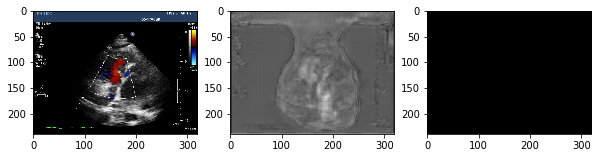

0 / 197,val_loss:0.005505367647856474

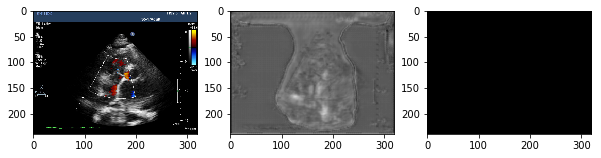

1 / 197,val_loss:0.005753171164542437

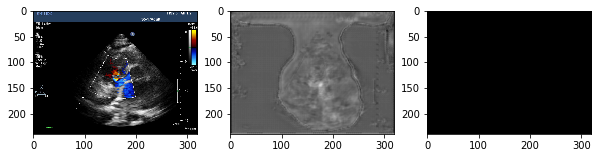

2 / 197,val_loss:0.005869879852980375

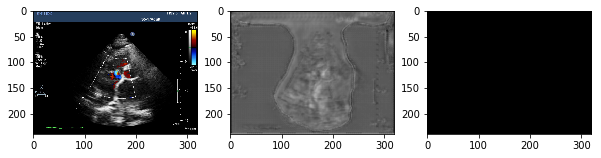

3 / 197,val_loss:0.0055721113458275795

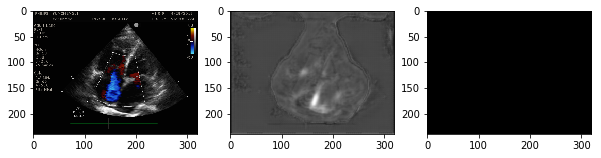

4 / 197,val_loss:0.005306780803948641

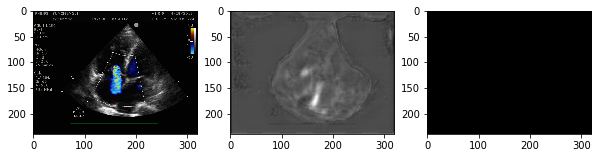

5 / 197,val_loss:0.005313534289598465

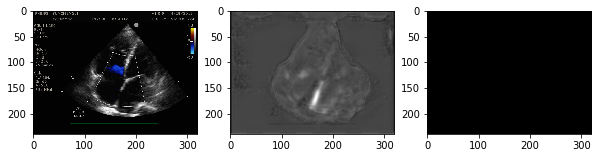

6 / 197,val_loss:0.005156456492841244

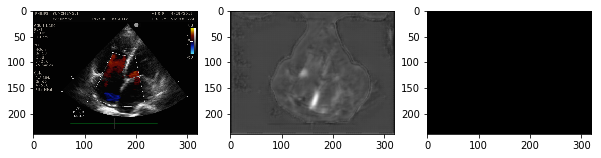

7 / 197,val_loss:0.004303953610360622

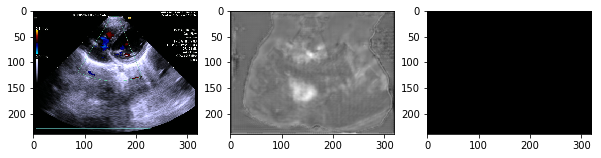

8 / 197,val_loss:0.004410674329847097

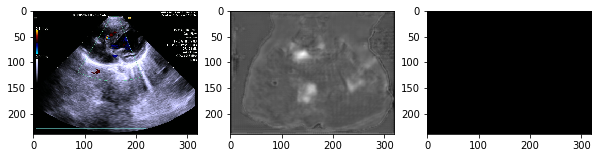

9 / 197,val_loss:0.0027969200164079666

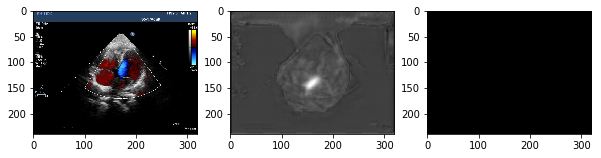

10 / 197,val_loss:0.0036490443162620068

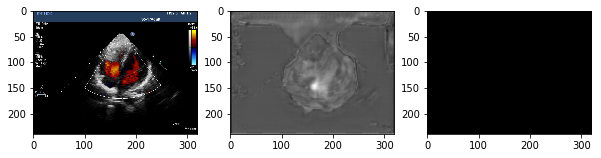

11 / 197,val_loss:0.0036331145092844963

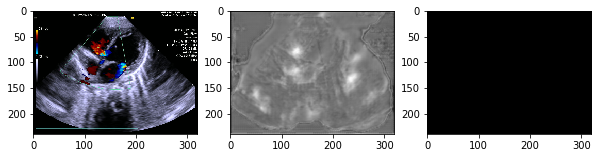

12 / 197,val_loss:0.004554940387606621

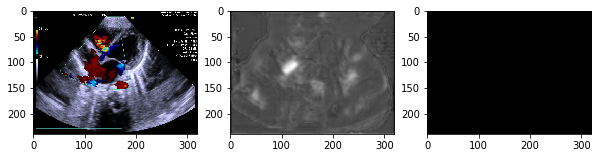

13 / 197,val_loss:0.004806262440979481

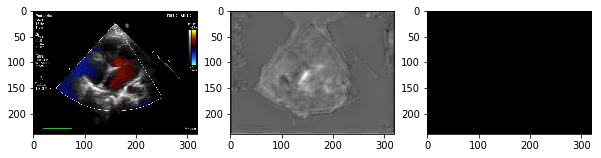

14 / 197,val_loss:0.002927316352725029

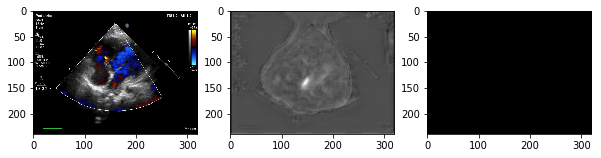

15 / 197,val_loss:0.0029142091516405344

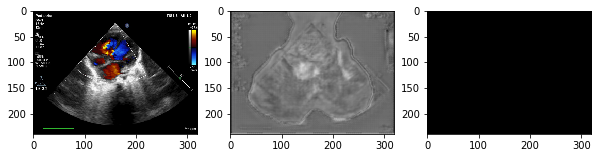

16 / 197,val_loss:0.002963185077533126

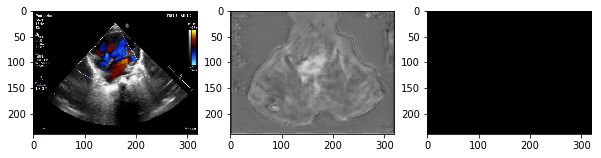

17 / 197,val_loss:0.004942205268889666

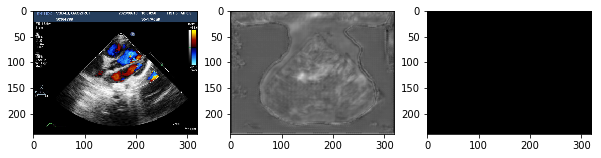

18 / 197,val_loss:0.003671931568533182

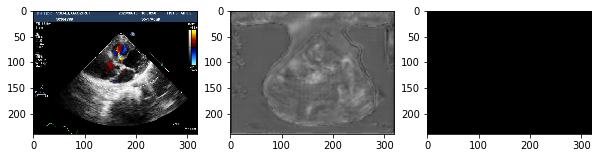

19 / 197,val_loss:0.004464037250727415

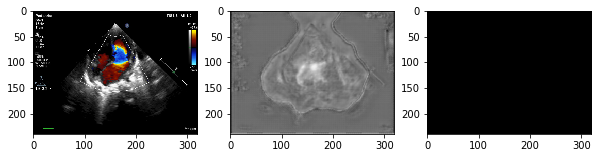

20 / 197,val_loss:0.003525760490447283

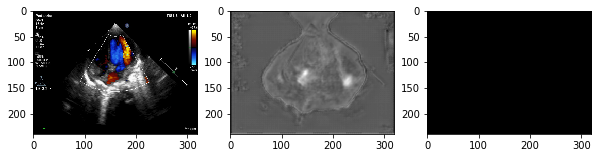

21 / 197,val_loss:0.006148728542029858

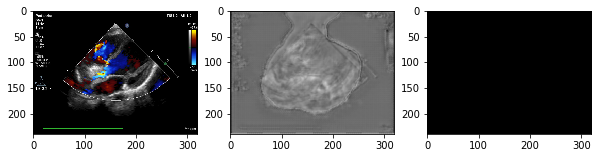

22 / 197,val_loss:0.007117837201803923

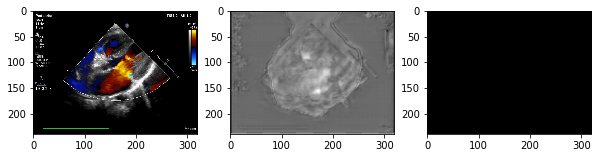

23 / 197,val_loss:0.007867230102419853

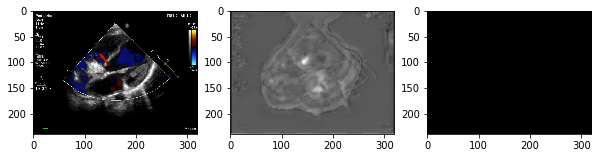

24 / 197,val_loss:0.007554476615041494

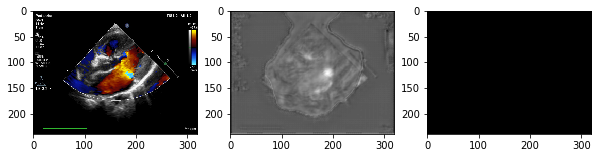

25 / 197,val_loss:0.004353986121714115

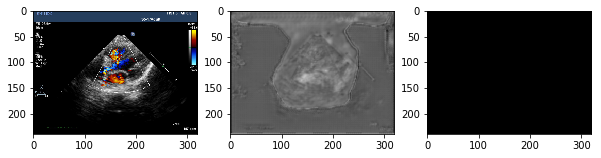

26 / 197,val_loss:0.002989943837746978

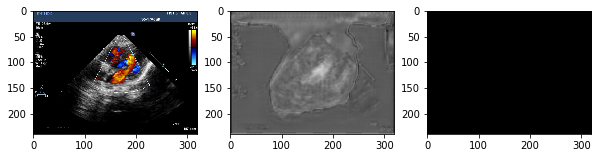

27 / 197,val_loss:0.0027469005435705185

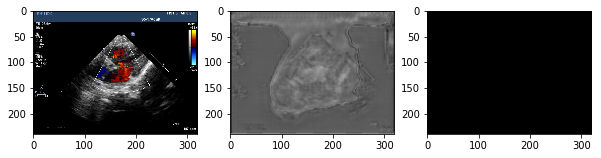

28 / 197,val_loss:0.0024908764753490686

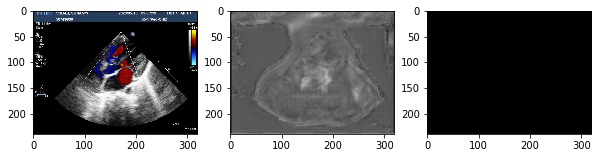

29 / 197,val_loss:0.004063929431140423

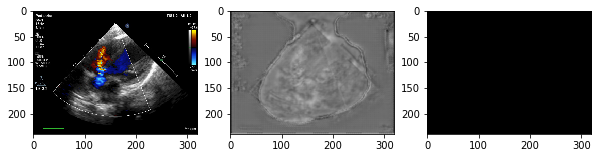

30 / 197,val_loss:0.005643954500555992

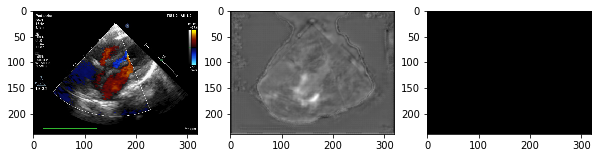

31 / 197,val_loss:0.006137822289019823

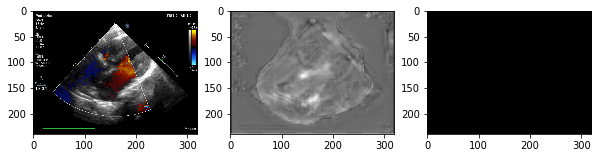

32 / 197,val_loss:0.004977086093276739

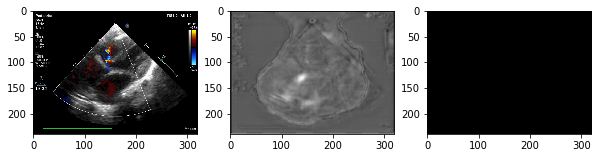

33 / 197,val_loss:0.005129029508680105

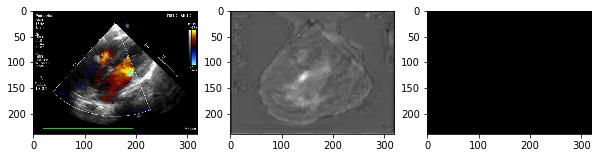

34 / 197,val_loss:0.0038725342601537704

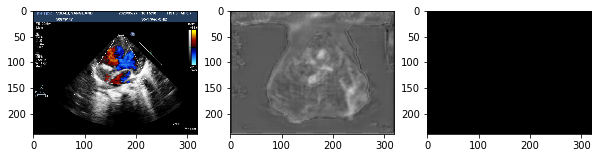

35 / 197,val_loss:0.002584660891443491

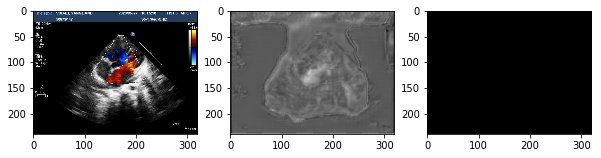

36 / 197,val_loss:0.0038995470385998487

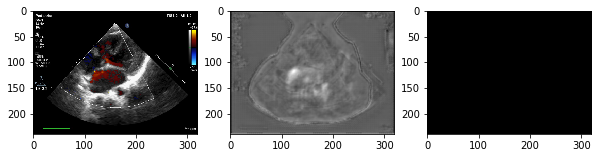

37 / 197,val_loss:0.004282940179109573

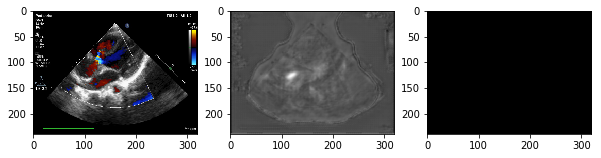

38 / 197,val_loss:0.004174530040472746

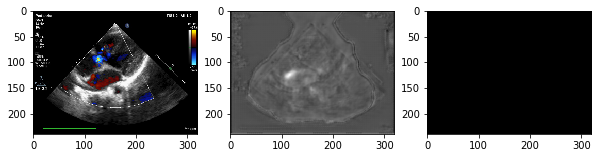

39 / 197,val_loss:0.00460317125543952

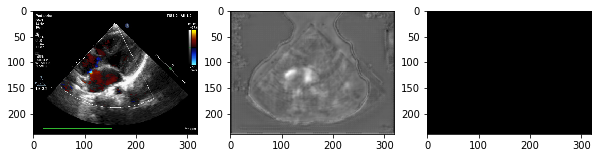

40 / 197,val_loss:0.003524715779349208

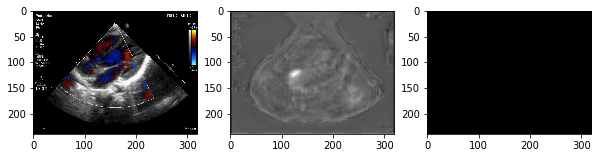

41 / 197,val_loss:0.005588325671851635

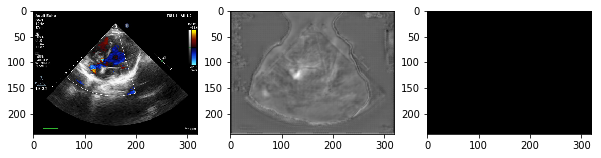

42 / 197,val_loss:0.002786922501400113

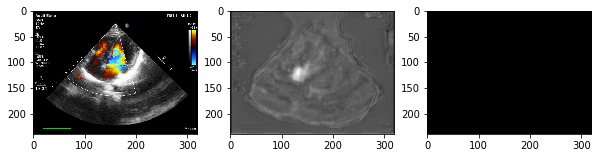

43 / 197,val_loss:0.0033778403885662556

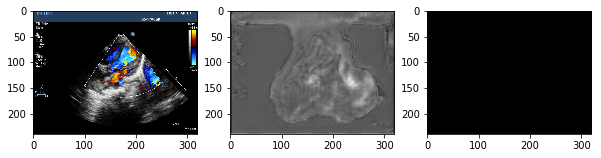

44 / 197,val_loss:0.003006382379680872

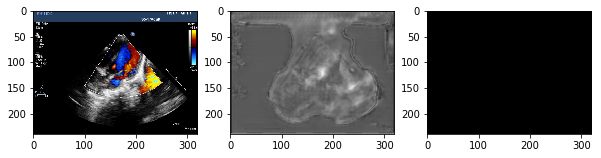

45 / 197,val_loss:0.0031335956882685423

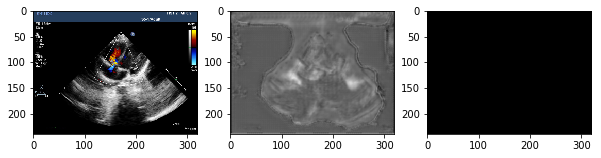

46 / 197,val_loss:0.0026427230332046747

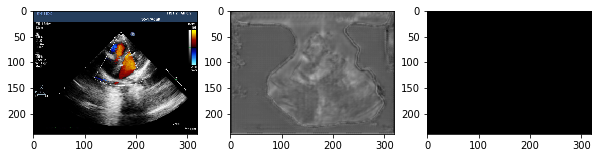

47 / 197,val_loss:0.0029924435075372458

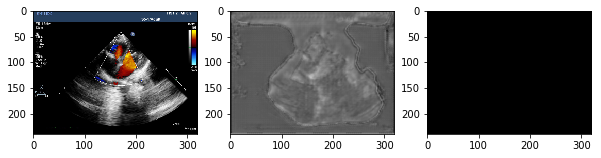

48 / 197,val_loss:0.0031350753270089626

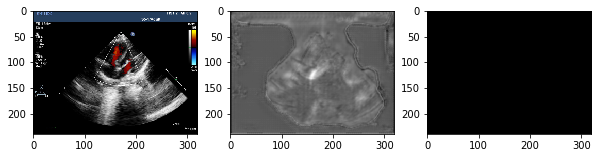

49 / 197,val_loss:0.0032142142299562693

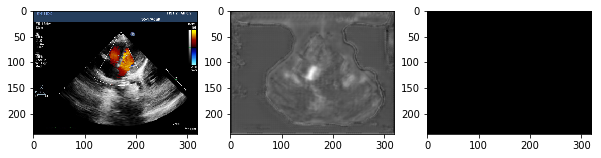

50 / 197,val_loss:0.0023170148488134146

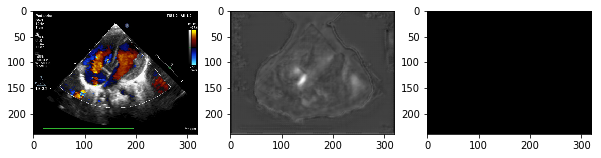

51 / 197,val_loss:0.0026298202574253082

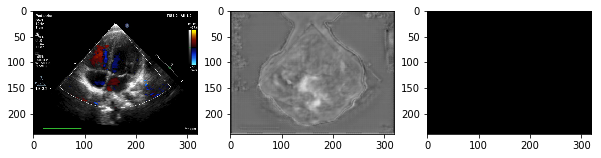

52 / 197,val_loss:0.002710714004933834

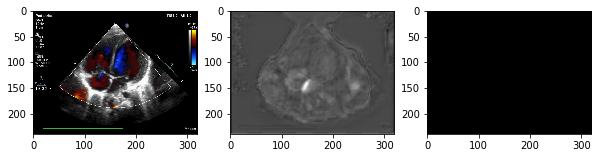

53 / 197,val_loss:0.003266628598794341

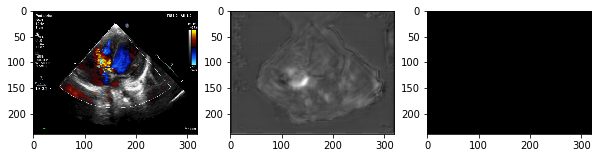

54 / 197,val_loss:0.003938577603548765

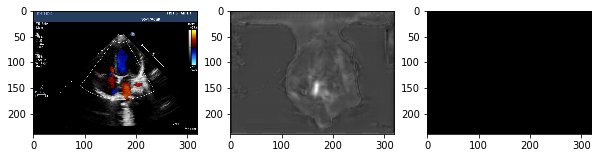

55 / 197,val_loss:0.0033100885339081287

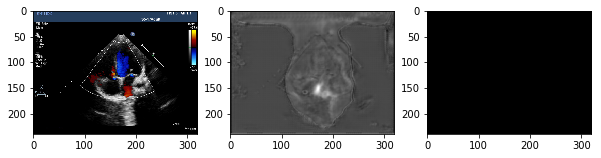

56 / 197,val_loss:0.003393669845536351

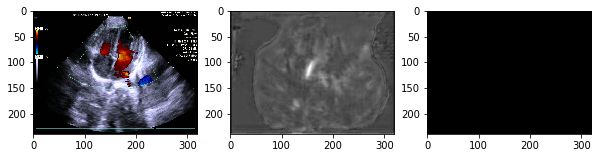

57 / 197,val_loss:0.003013945883139968

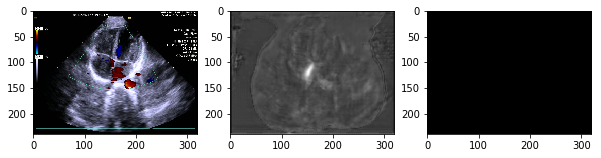

58 / 197,val_loss:0.0032619843259453773

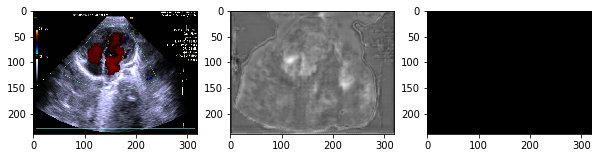

59 / 197,val_loss:0.002556095365434885

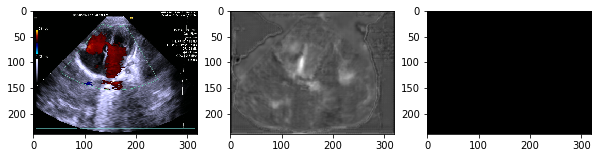

60 / 197,val_loss:0.002884239424020052

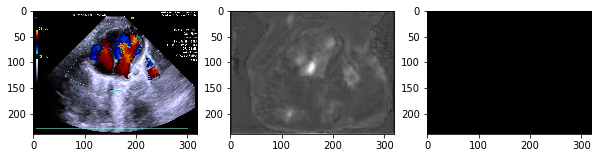

61 / 197,val_loss:0.0033202709164470434

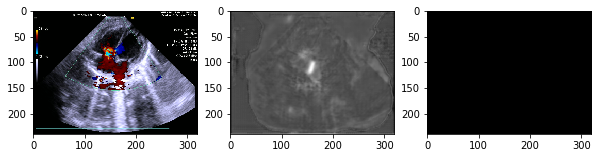

62 / 197,val_loss:0.002881519729271531

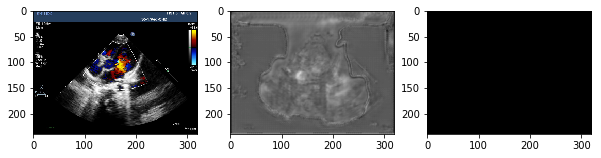

63 / 197,val_loss:0.001945072435773909

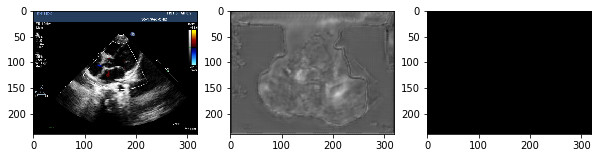

64 / 197,val_loss:0.0018636035965755582

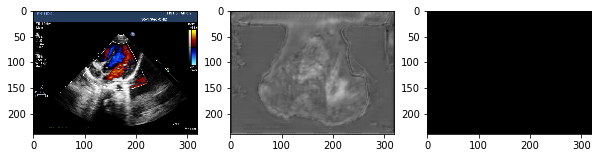

65 / 197,val_loss:0.0017923761624842882

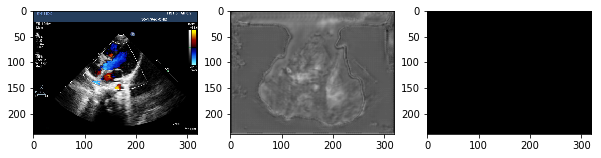

66 / 197,val_loss:0.0018516711425036192

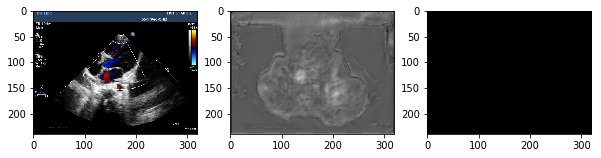

67 / 197,val_loss:0.0027886477764695883

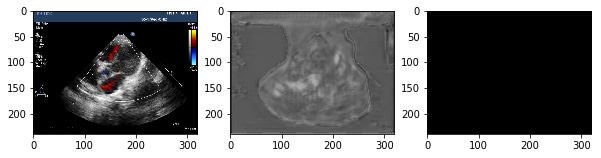

68 / 197,val_loss:0.0034015693236142397

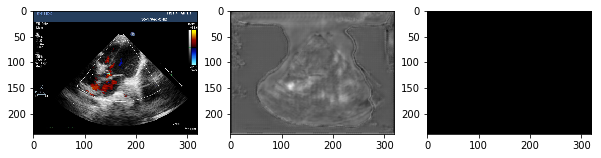

69 / 197,val_loss:0.003767378395423293

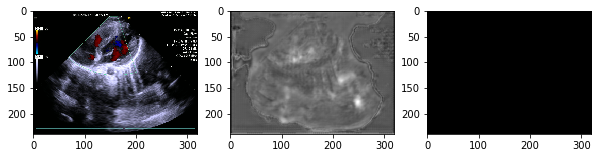

70 / 197,val_loss:0.0050910538993775845

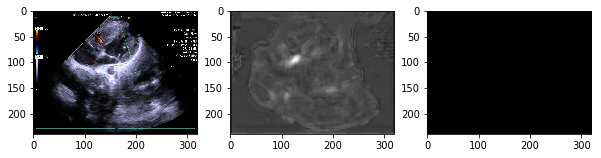

71 / 197,val_loss:0.004216719418764114

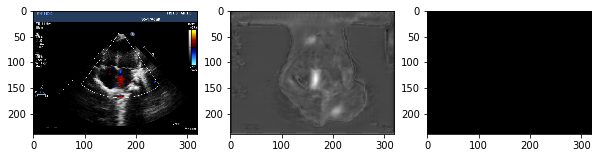

72 / 197,val_loss:0.0028723988216370344

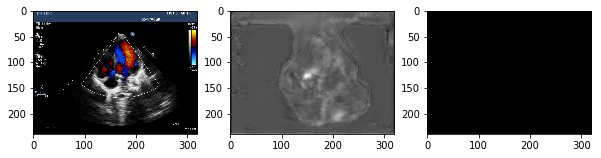

73 / 197,val_loss:0.0028036702424287796

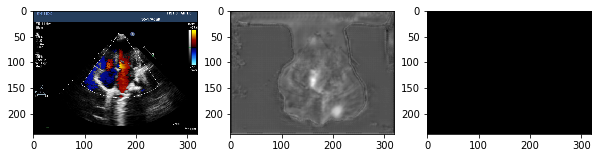

74 / 197,val_loss:0.0031771494541317225

KeyboardInterrupt: 

In [16]:
val_loss = val(plot=True)

In [18]:
loss_septum = mse(output['septum'],y[:,0:1].float())

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])